###  你们先试试写写然后就可以看看文章里讲怎么建造portfolio那一块了

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os #如果你没有用gpu做machine leaning就忽略这两条
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #如果你没有用gpu就忽略这两条
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn import preprocessing 

In [70]:
df = pd.read_csv('C:/Users/Zackt/Documents/100 stock price 5 years.csv'  , index_col = 0)

### Preprocessing data

In [71]:

temp = df.iloc[:700,:].dropna()#  use near 2 years data
temp_1 = temp.shift(1)

net_change = (temp - temp_1).dropna(0) # calculate the net change
pct_change = temp.pct_change().dropna(0)

#test = preprocessing.normalize(df)
test = pct_change # use percentage change
test.shape

(698, 100)

### Construct data (这一块的activation，optimizer， loss， 还有 data preprocessing是我们要反复实验的）
### 还有关于使用什么样的数据也是要调整测试的， 是net change， percentage change 还是last price，需不需要normalize 或者 standardize 等等
### 我先用最常见的几个写了
### '''先建个一层的'''， 可以试试deeper的层数，等交完796作业

In [68]:

encoding_dim = 30 #中间层，随便设，别大于input
dim = test.shape[1]

# 输入层
input_stock = Input(shape=(dim,))
#  中间encoding层
encoded = Dense(encoding_dim, activation='relu')(input_stock)
# 输出decoding层
decoded = Dense(dim, activation='linear')(encoded)

# initial model
autoencoder = Model(input_stock, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
encoder = Model(input_stock, encoded)

# training the model 要是想看过程把verbose 设为True
autoencoder.fit(test, test, shuffle=False, epochs=200, batch_size = 10 , verbose = False) 

### Predict and pick the stocks

In [86]:
predict = autoencoder.predict(test) # predict 重新得到输出层
# use 2 different norm to decide which stocks are market leader which are not
communal_information = np.linalg.norm((test - predict),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : test.columns[ranking] })
ranks

,communal,index
0,0.043302,CF
1,0.045291,LULU
2,0.046929,NFLX
3,0.048654,TSLA
4,0.051081,NVDA
...,...,...
95,0.238818,VRSN
96,0.240086,INTU
97,0.250026,ASML
98,0.255287,ROST


### Let see what the best one looks like ( Pretty good, One of the best Market follower)

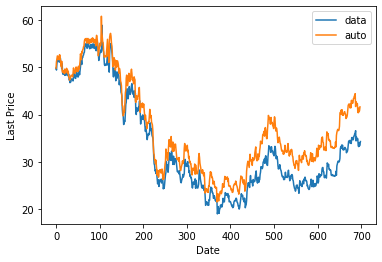

In [81]:
stock_index = ranking[0]
predict_path = [df.iloc[0,stock_index]]
for i in range(1,test.shape[0]):
    predict_path.append(predict_path[i-1] * (1+predict[i,stock_index]))

plt.plot(np.array(temp.iloc[:,stock_index] ) , label = 'data')
plt.plot(predict_path, label = 'auto')
plt.xlabel('Date')
plt.ylabel('Last Price')
# plt.plot(df.iloc[0,stock_index] + np.cumsum(predict[:,stock_index]) , label = 'autoencoder')
plt.legend()

### Let see what the worst one looks like (could be good too) we need stock that does not follow the market
##### the communal information totally cannot reproduce the path means
##### The communal information is the most shared information that was saved during dimension reduction.
##### Thus, the faliure of reproducing the path means the every other stocks in the market doest share too much information with this stocl

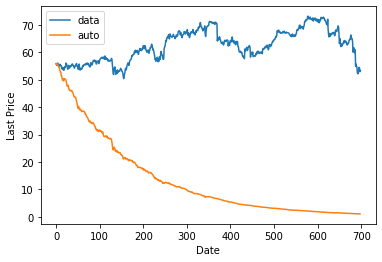

In [84]:
stock_index = ranking[-1]
predict_path = [df.iloc[0,stock_index]]
for i in range(1,test.shape[0]):
    predict_path.append(predict_path[i-1] * (1+predict[i,stock_index]))

plt.plot(np.array(temp.iloc[:,stock_index] ) , label = 'data')
plt.plot(predict_path, label = 'auto')
plt.xlabel('Date')
plt.ylabel('Last Price')
# plt.plot(df.iloc[0,stock_index] + np.cumsum(predict[:,stock_index]) , label = 'autoencoder')
plt.legend()

### Pick 50(or 20 or 10 or ...) from this ranking list
##### we want both market follower and no-market follower

### 在改成class 不用看

In [ ]:
class autoencoder:
    def __init__(self,data , model = 'Nan', optimizer = 'adam', loss = 'mean_squared_error'):
        self.data = data
        self.optimizer = optimizer
        self.loss = loss
        if model == 'NaN':
            self.construct_model()
            
    def construct_model(self):
        encoding_dim = 50
        dim = test.shape[1]


        input_stock = Input(shape=(dim,))

        encoded = Dense(encoding_dim, activation='relu')(input_stock)

        decoded = Dense(dim, activation='linear')(encoded)


        self.autoencoder = Model(input_stock, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
    def train(self):
        self.autoencoder.fit(test, test, shuffle=False, epochs=200, batch_size = 10 , verbose = False) 